# image reconstruction

## Import libraries

In [114]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm import tqdm
import os
import random
import copy

## Load data

In [115]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2


In [116]:

directory_data  = './'
filename_data   = 'assignment_11_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

clean_image_train = data['label_train']
input_image_test  = data['input_test'] 
clean_image_test  = data['label_test']


In [117]:
input_image_test_copy = copy.deepcopy(input_image_test)
clean_image_train_copy = copy.deepcopy(clean_image_train)

input_train 데이터셋 만들기

In [118]:
def idx_list(input_image, idx, temp):
  #temp_input_test에서 0로 채워진 row 찾기
  col_idx_list = []
  row_idx_list = []
  #col
  col_idx_list.append([i for i, value in enumerate(input_image[idx][temp,:]) if value == 0])
  #row
  row_idx_list.append([i for i, value in enumerate(input_image[idx][:,temp]) if value == 0])
  
  idx_list = {'idx':idx, 'row': row_idx_list, 'col': col_idx_list}

  return idx_list

In [119]:
def generate_input_train(clean_image, idx_list, offset):
  #col과 row를 0으로 변환
  idx = idx_list['idx']+offset
  row_idx_list = idx_list['row']
  col_idx_list = idx_list['col']

  input_train_single = copy.deepcopy(clean_image[idx])
  #row
  for i in row_idx_list:
    input_train_single[i] = 0
  #col
  for i in col_idx_list:
    input_train_single[:,i] = 0

  return input_train_single

In [120]:
#input_image_test에서 검은 줄의 row, col
zero_idx = []
for i in range(len(input_image_test_copy)):
  zero_idx.append(idx_list(input_image_test_copy, i,120))

#row, col이 잘못 검출된 이미지의 idx
error_idx=[]
for i in zero_idx:
  row_len = len(i['row'][0])
  col_len = len(i['col'][0])
  if row_len > 50 or col_len > 50 :
    error_idx.append(i['idx'])

error_idx

[]

In [121]:
#0~ 400 : clean_image_train의 zero_idx을 0으로 변환
input_image_train=[]
for i in zero_idx:
  input = generate_input_train(clean_image_train_copy, i,0)
  input_image_train.append(input)

#400~800: clean_image_train의 zero_idx을 0으로 변환
for i in zero_idx:
  input = generate_input_train(clean_image_train_copy, i,400)
  input_image_train.append(input)

#에러 검사
zero_idx_train = []
for i in range(len(input_image_train)):
  zero_idx_train.append(idx_list(input_image_train, i,120))

error_idx_train=[]
for i in zero_idx_train:
  row_len = len(i['row'][0])
  col_len = len(i['col'][0])
  if row_len > 50 or col_len > 50 :
    error_idx_train.append(i['idx'])

error_idx_train

[]

## plot data

In [122]:
def plot_image(title, image, k):
    
    nRow = 2
    nCol = 2
    size = 3
    
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow):
        for c in range(nCol):
            #k = r * nCol * 10 + c * 4 + 10
            axes[r, c].imshow(image[k], cmap='gray', vmin=0, vmax=1)
            k+=1
    plt.tight_layout()
    plt.show()

In [123]:
#plot_image('input image (testing)', input_image_train, 0)

In [124]:
#plot_image_temp('input image (testing)', input_image_test)

In [125]:
#plot_image('label image (training)', clean_image_train)

In [126]:
#plot_image('clean image (testing)', clean_image_test)

## custom data loader for the training data

In [127]:
class dataset(Dataset):
    
    def __init__(self, clean_image, input_image):
        
        self.clean_image = clean_image
        self.input_image = input_image

    def __getitem__(self, index):
        # ==================================================
        # modify the codes for training data
        #        
        clean_image = self.clean_image[index]
        clean_image = torch.FloatTensor(clean_image).unsqueeze(dim=0)

        input_image = self.input_image[index]
        input_image = torch.FloatTensor(input_image).unsqueeze(dim=0)


        return (clean_image, input_image) # trainingdata도 반환하게 하기, 영상 16:31
        #    
        # ==================================================

    def __len__(self):

        number_image = self.clean_image.shape[0]

        return number_image    

## setting device

In [128]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [129]:
print(device)

cuda


## custom data loader for the testing data

In [130]:
input_image_test = torch.FloatTensor(input_image_test).unsqueeze(dim=1)
clean_image_test = torch.FloatTensor(clean_image_test).unsqueeze(dim=1)

input_image_test = input_image_test.to(device)
clean_image_test = clean_image_test.to(device)

## construct datasets and dataloaders for training and testing

In [131]:
# ==================================================
# determine the mini-batch size
#
size_minibatch      = 10
learning_rate = 0.005
number_epoch=1600
weight_decay    = 0.003
#
# ==================================================

dataset_train       = dataset(clean_image_train, input_image_train)
dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)

## construct a neural network 

In [132]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # -------------------------------------------------
        # Encoder
        # -------------------------------------------------
        self.e_layer1 = nn.Sequential(
                        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.ReLU(),
                        nn.BatchNorm2d(8), #out_channels 수와 BN2 수 동일해야한다
        )
        
        self.e_layer2 = nn.Sequential(
                        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.ReLU(),
        )

        self.e_layer3 = nn.Sequential(
                        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.ReLU(),
        )
        
        self.e_layer4 = nn.Sequential(
                        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
        )
        

        # -------------------------------------------------
        # Decoder
        # -------------------------------------------------
        
        
        self.d_layer1 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
        )
        
        self.d_layer2 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.ReLU(),
        )

        self.d_layer3 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.ReLU(),
        )

        self.d_layer4 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.Sigmoid(),#out_channels 1, 마지막 sigmoid
        )
        

        # -------------------------------------------------
        # Network
        # -------------------------------------------------
        self.network = nn.Sequential(
                        self.e_layer1,
                        self.e_layer2,
                        self.e_layer3,
                        self.e_layer4,
                        self.d_layer1, 
                        self.d_layer2,
                        self.d_layer3,
                        self.d_layer4,
        )

        self.initialize_weight()

    def forward(self,x):
    
        out = self.network(x)
      
        return out

    # ======================================================================
    # initialize weights
    # ======================================================================
    def initialize_weight(self):
            
        for m in self.network.modules():
            
            if isinstance(m, nn.Conv2d):

                nn.init.xavier_uniform_(m.weight) 
                
                if m.bias is not None:

                    nn.init.constant_(m.bias, 1)
                    pass
                    
            elif isinstance(m, nn.BatchNorm2d):
                
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 1)
                
            elif isinstance(m, nn.Linear): 
                
                nn.init.xavier_uniform_(m.weight) 

                if m.bias is not None:

                    nn.init.constant_(m.bias, 1)
                    pass

## build the network

In [133]:
model = Network().to(device)

# ==================================================
# determine the optimiser and its associated hyper-parameters
#

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#
# ==================================================

## compute the prediction

In [134]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

compute the loss

In [135]:
def compute_loss(prediction, label):
    # ==================================================
    # fill up the blank
    #
    criterion   = nn.MSELoss()
    # 
    # ==================================================
    loss        = criterion(prediction, label)

    return loss

compute the accurcy

In [136]:
def compute_accuracy(prediction, label):

    prediction  = prediction.squeeze(axis=1)
    label       = label.squeeze(axis=1)
    mse_loss    = torch.mean((prediction - label) ** 2)

    if mse_loss == 0.0:
        psnr = 100
    else:
        psnr = 10 * torch.log10(1 / mse_loss)

    psnr = psnr.item()
    
    return psnr

## compute the PSNR metric

- data1 : mini-batch-size x channel x height x width (torch tensor)
- data2 : mini-batch-size x channel x height x width (torch tensor)

In [137]:
def compute_psnr(data1, data2):

    mse         = nn.MSELoss()(data1, data2)
    mse_value   = mse.item()
    psnr        = 10 * np.log10(1 / mse_value)

    return psnr

## Variable for the learning curves

In [138]:
psnr_test = np.zeros(number_epoch)

## train

In [139]:
def train(model, optimizer, dataloader):

    model.train()

    # ==================================================
    # fill up the blank
    #
    loss_epoch      = []
    accuracy_epoch  = []

    model.train()

    for index_batch, (original, blur) in enumerate(dataloader):

        original    = original.to(device)
        blur        = blur.to(device)
        
        prediction  = compute_prediction(model, blur)
        loss        = compute_loss(prediction, original)
        accuracy    = compute_accuracy(prediction, original)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch.append(loss.item())
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)  



    #
    # ==================================================

## test

In [140]:
def test(model, input_image, clean_image):

    model.eval()

    num_steps   = 40
    steps       = np.linspace(0, input_image.shape[0], num_steps+1).astype(int)
    psnr_steps  = np.zeros(num_steps)
    
    for i in range(num_steps):
        input           = input_image[steps[i]:steps[i+1], :, :, :]
        clean           = clean_image[steps[i]:steps[i+1], :, :, :]
        prediction      = compute_prediction(model, input)
        psnr_steps[i]   = compute_psnr(clean, prediction)
    
    psnr = psnr_steps.mean()
    
    return psnr

## train and test

In [141]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    train(model, optimizer, dataloader_train)

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    psnr            = test(model, input_image_test, clean_image_test)
    psnr_test[i]    = psnr

100%|██████████| 1600/1600 [17:50<00:00,  1.49it/s]


---

## functions for presenting the results

---

In [142]:
def function_result_01():
    
    title           = 'psnr (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'psnr'
    
    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(psnr_test, '-')
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [143]:
def function_result_02():
    
    nRow = 9
    nCol = 4
    size = 3
    
    title = 'testing results'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    model.eval()

    prediction  = compute_prediction(model, input_image_test)

    input_image = input_image_test.detach().cpu().squeeze(axis=1)
    clean_image = clean_image_test.detach().cpu().squeeze(axis=1)
    prediction  = prediction.detach().cpu().squeeze(axis=1)

    nStep = 3

    for r in range(3):
        for c in range(nCol):
            k = r * nCol * 10 + c * 4 + 10
            axes[0 + r * nStep, c].imshow(input_image[k], cmap='gray')
            axes[1 + r * nStep, c].imshow(clean_image[k], cmap='gray', vmin=0, vmax=1)
            axes[2 + r * nStep, c].imshow(prediction[k], cmap='gray', vmin=0, vmax=1)

            axes[0 + r * nStep, c].xaxis.set_visible(False)
            axes[1 + r * nStep, c].xaxis.set_visible(False)
            axes[2 + r * nStep, c].xaxis.set_visible(False)
            
            axes[0 + r * nStep, c].yaxis.set_visible(False)
            axes[1 + r * nStep, c].yaxis.set_visible(False)
            axes[2 + r * nStep, c].yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()

In [144]:
def function_result_03():
    
    print('final testing psnr = %9.8f' % (psnr_test[-1]))

---

## results 

---


################################################################################
#
# RESULT # 01
#
################################################################################



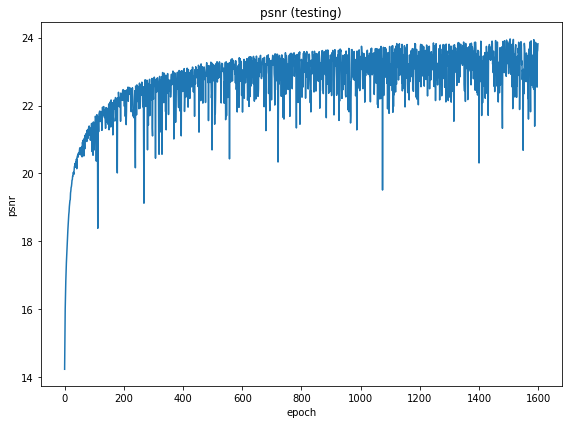


################################################################################
#
# RESULT # 02
#
################################################################################



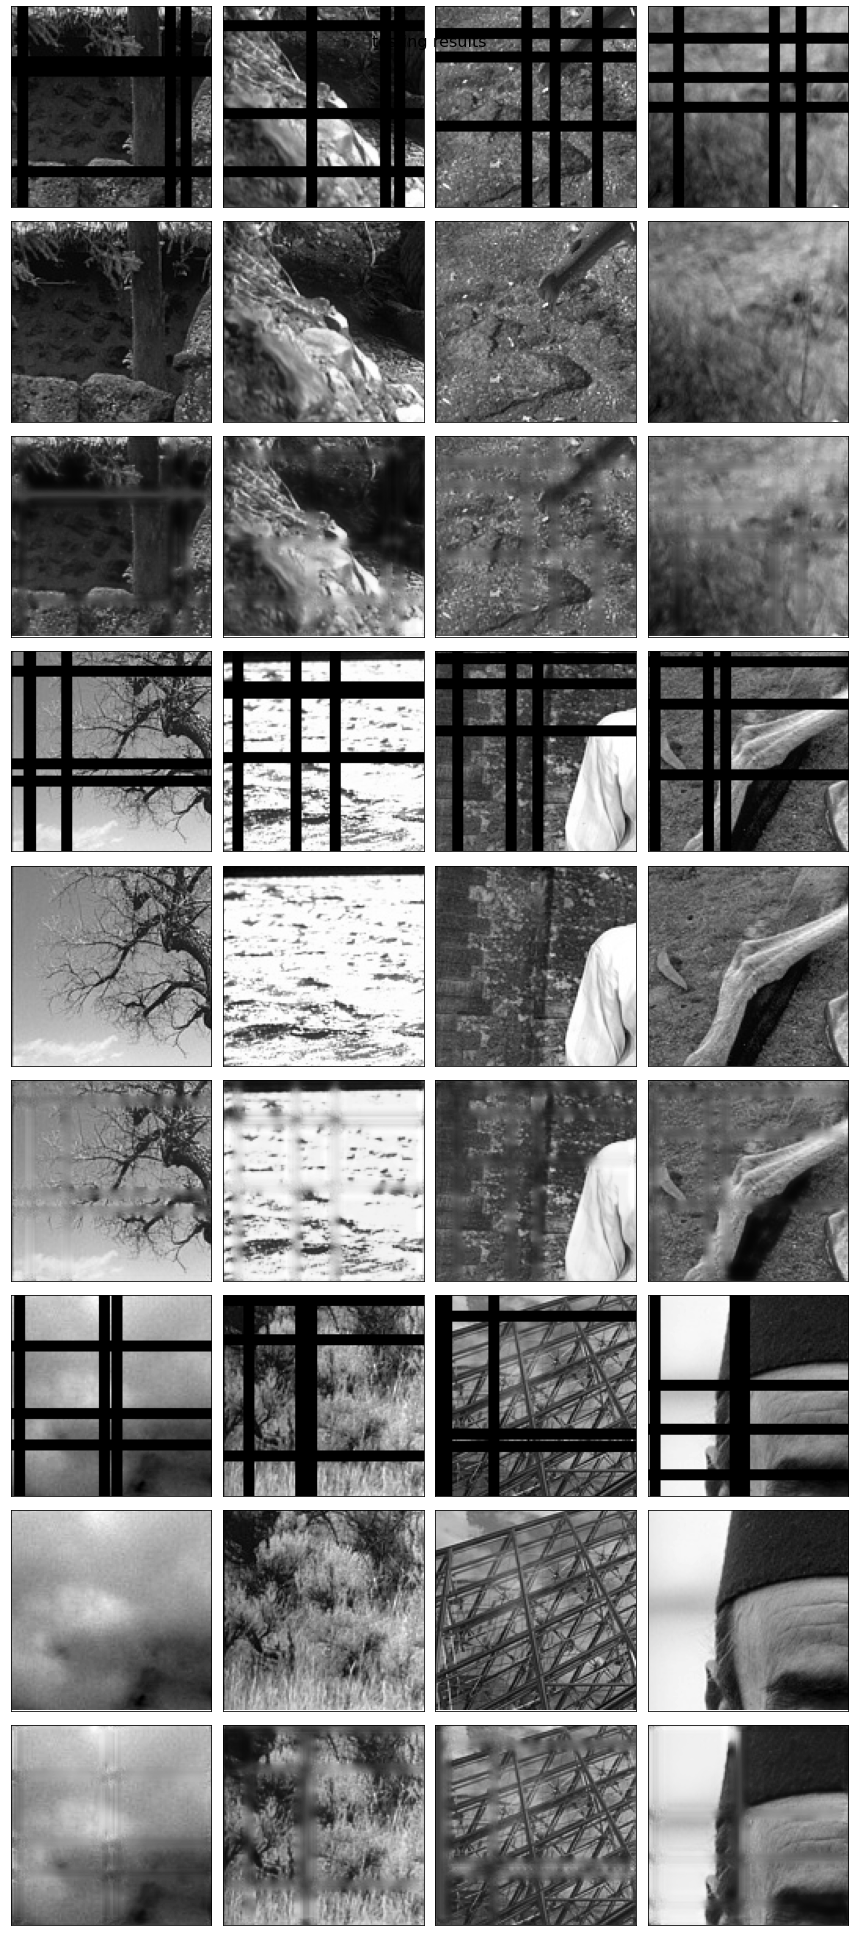


################################################################################
#
# RESULT # 03
#
################################################################################

final testing psnr = 23.81685173


In [145]:
number_result = 3 

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1)
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)

In [146]:
!apt-get update

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 261 kB in 2s (135 kB/s)
Reading package lis

In [147]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
texlive is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-xetex is already the newest version (2017.20180305-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [150]:
!jupyter nbconvert --to PDF '/content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2/assignment_11_net.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2/assignment_11_net.ipynb to PDF
[NbConvertApp] Support files will be in assignment_11_net_files/
[NbConvertApp] Making directory ./assignment_11_net_files
[NbConvertApp] Making directory ./assignment_11_net_files
[NbConvertApp] Writing 80759 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1224067 bytes to /content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2/assignment_11_net.pdf
